In [3]:
# importing libraries 
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df= pd.read_csv('/Users/gauravsharma/Documents/DIT/Lectures/KI5 Case Study Embedded Control Solutions/Project/Model/WISDM_ar_v1.1_raw.txt',on_bad_lines='skip', header = None, names = columns)

In [5]:
df['activity'].value_counts()

Walking       418394
Jogging       336445
Upstairs      122869
Downstairs    100425
Sitting        59939
Standing       48394
Name: activity, dtype: int64

In [6]:
df.head(10)

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
5,33,Jogging,49106442306000,1.375655,-2.492524,-6.510526;
6,33,Jogging,49106542312000,-0.612916,10.569390,5.706926;
7,33,Jogging,49106652389000,-0.503953,13.947236,7.0553403;
8,33,Jogging,49106762313000,-8.430995,11.413852,5.134871;
9,33,Jogging,49106872299000,0.953424,1.375655,1.6480621;


In [7]:
df.shape

(1086466, 6)

In [8]:
df.isnull().value_counts()

user   activity  timestamp  x-axis  y-axis  z-axis
False  False     False      False   False   False     1086465
                                            True            1
dtype: int64

In [9]:
# removing null values rows
df=df.dropna()

In [10]:
df.isnull().value_counts()

user   activity  timestamp  x-axis  y-axis  z-axis
False  False     False      False   False   False     1086465
dtype: int64

In [11]:
# drop rows where timestamp is 0
df = df[df['timestamp'] != 0]

In [12]:
df = df[df['activity'].str.contains('Upstairs') == False]
df = df[df['activity'].str.contains('Downstairs') == False]
df = df[df['activity'].str.contains('Standing') == False]

In [13]:
# d=(df['activity']=='Jogging').value_counts()
# d

In [14]:
df['activity'].value_counts()

Walking    417901
Jogging    324600
Sitting     59939
Name: activity, dtype: int64

In [15]:
df.shape

(802440, 6)

In [16]:
# transforming the z-axis to float
df['z-axis'] = df['z-axis'].str.replace(';', '')
df['z-axis'] = df['z-axis'].apply(lambda x:float(x))

In [17]:
# arrange data in ascending order of user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

Exploratory Data Analysis
Analyzing class label distribution —

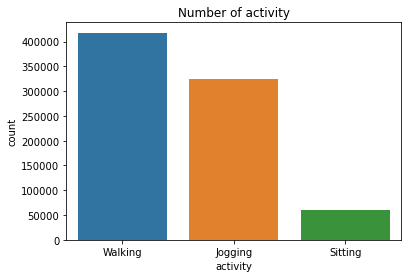

In [18]:
sns.set_style()
sns.countplot(x='activity', data = df)
plt.title('Number of activity')
plt.show()

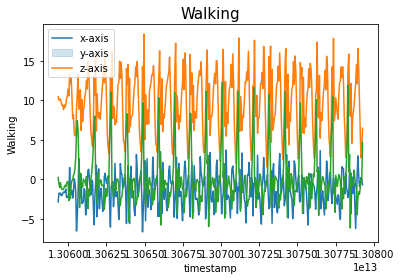

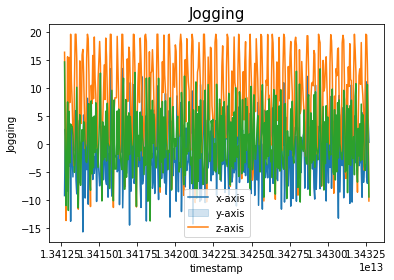

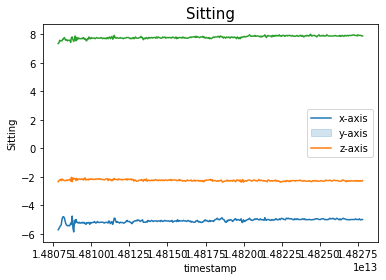

In [19]:
activities = ['Walking', 'Jogging', 'Sitting']
for i in activities:
    data36 = df[(df['user'] == 36) & (df['activity'] == i)][:400]
    sns.lineplot(y = 'x-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'y-axis', x = 'timestamp', data = data36)
    sns.lineplot(y = 'z-axis', x = 'timestamp', data = data36)
    plt.legend(['x-axis', 'y-axis', 'z-axis'])
    plt.ylabel(i)
    plt.title(i, fontsize = 15)
    plt.show()

In [20]:
#Model parameters:-
random_seed = 42   
n_time_steps = 8 #corresponding to 2.5 secs of activity @20Hz of data collection requency
step = 2 # 40 data out of 50 is passed
n_features = 3 # acc x,y,z
n_classes = 3 #walking, jogging, sitting

In [21]:
segments = [] #acceleration in x,y,z
labels = [] #activity type 

for i in range(0,  df.shape[0]- n_time_steps, step):  

    xs = df['x-axis'].values[i: i + 8]
    ys = df['y-axis'].values[i: i + 8]
    zs = df['z-axis'].values[i: i + 8]
    
    from scipy import stats
    segments.append([xs,ys,zs])
    label=stats.mode(df['activity'][i: i + 8])[0][0] #tell the class of activity sitting, walking, running 
    labels.append(label)

# # #reshape the segments which is (list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [22]:
np.shape(reshaped_segments)

(401216, 8, 3)

In [23]:
np.shape(labels)

(401216, 3)

Splitting data into train and test sets –

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)

In [25]:
np.shape(X_train[2])

(8, 3)

In [26]:
X_test[0]

array([[ 6.09      ,  7.86      ,  8.92      ],
       [ 2.76      , -2.98      , -5.37      ],
       [-3.64      , -4.99      , 14.56      ],
       [11.41      ,  9.51      , 14.94      ],
       [19.57      , 17.67      ,  3.72      ],
       [ 0.8       ,  0.10896278, -2.5606253 ],
       [-1.7978859 ,  6.851035  , -1.2666923 ],
       [-0.95342433,  1.334794  , -0.50395286]], dtype=float32)

Building Model Architecture

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

In [28]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5)) 
# Dense layer with ReLu function
model.add(Dense(units = 64, activation='relu'))
# Softmax layer for getting probability of each class
model.add(Dense(y_train.shape[1], activation = 'softmax')) #normalize the output of a network to a probability distribution over predicted output classes
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-30 23:09:43.744061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-30 23:09:43.744510: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
# model.summary()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 76,035
Trainable params: 76,035
Non-trainable params: 0
_________________________________________________________________


In [30]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [31]:
plot_model(model, to_file='my-model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [32]:
#Model parameters
n_epochs = 10
batch_size = 1024 #batch size for data feeding into model  
learning_rate = 0.0025 #alpa
l2_loss = 0.0015 

In [33]:
# Model Training & Evaluation!
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split = 0.20, batch_size = batch_size, verbose = 1)

Epoch 1/10


2022-07-30 23:09:44.386948: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-30 23:09:45.102898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 23:09:45.286178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/251 [..............................] - ETA: 6:00 - loss: 1.1335 - accuracy: 0.3594

2022-07-30 23:09:45.672207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8853

2022-07-30 23:09:51.143544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 23:09:51.209648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


251/251 [==============================] - 8s 24ms/step - loss: 0.2881 - accuracy: 0.8853 - val_loss: 0.1341 - val_accuracy: 0.9543
Epoch 2/10
251/251 [==============================] - 5s 21ms/step - loss: 0.1223 - accuracy: 0.9596 - val_loss: 0.0899 - val_accuracy: 0.9721
Epoch 3/10
251/251 [==============================] - 6s 22ms/step - loss: 0.0910 - accuracy: 0.9721 - val_loss: 0.0732 - val_accuracy: 0.9788
Epoch 4/10
251/251 [==============================] - 5s 22ms/step - loss: 0.0775 - accuracy: 0.9774 - val_loss: 0.0641 - val_accuracy: 0.9813
Epoch 5/10
251/251 [==============================] - 5s 22ms/step - loss: 0.0675 - accuracy: 0.9807 - val_loss: 0.0638 - val_accuracy: 0.9812
Epoch 6/10
251/251 [==============================] - 6s 22ms/step - loss: 0.0618 - accuracy: 0.9825 - val_loss: 0.0594 - val_accuracy: 0.9825
Epoch 7/10
251/251 [==============================] - 6s 22ms/step - loss: 0.0581 - accuracy: 0.9837 - val_loss: 0.0532 - val_accuracy: 0.9845
Epoch 8/10

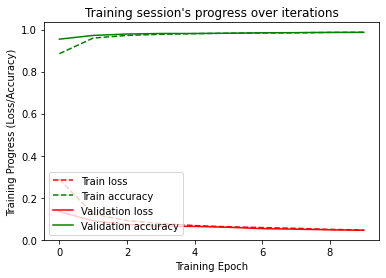

In [34]:
# Plotting training and validation accuracy and cross-entropy loss against a number of epochs –
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0) 
plt.show()

In [35]:
# performance of the trained model on the test dataset –
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

79/79 [==============================] - 1s 13ms/step - loss: 0.0484 - accuracy: 0.9862
Test Accuracy : 0.9862419962882996
Test Loss : 0.04843896999955177


  16/2508 [..............................] - ETA: 8s   

2022-07-30 23:10:42.292534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-30 23:10:42.352098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2508/2508 [==============================] - 8s 3ms/step


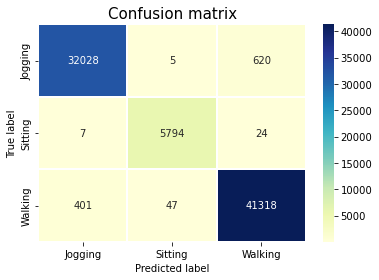

In [36]:
# Confusion matrix
predictions = model.predict(X_test)  #prediction from test data in form of probability
class_labels = ['Jogging', 'Sitting', 'Walking']
max_test = np.argmax(y_test, axis=1) # np.argmax -->Returns the indices of the maximum values along an axis.
max_predictions = np.argmax(predictions, axis=1) # np.argmax -->Returns the indices of the maximum values along an axis.
from sklearn.metrics import classification_report,confusion_matrix
confs_mat = confusion_matrix(max_test, max_predictions)

sns.heatmap(confs_mat, xticklabels = class_labels, yticklabels = class_labels, annot = True, linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [37]:
max_predictions

array([2, 0, 0, ..., 2, 2, 0])

In [38]:
predict_class=[]
for i in range(0,max_predictions.shape[0],1):
    if max_predictions[i]==0:
        temp='Jogging'
    if max_predictions[i]==1:
        temp='Sitting'
    if max_predictions[i]==2:
        temp='Walking'
    predict_class.append([temp])

In [39]:
type(predict_class)

list

In [40]:
predict_class

[['Walking'],
 ['Jogging'],
 ['Jogging'],
 ['Walking'],
 ['Jogging'],
 ['Sitting'],
 ['Walking'],
 ['Walking'],
 ['Jogging'],
 ['Jogging'],
 ['Jogging'],
 ['Walking'],
 ['Jogging'],
 ['Walking'],
 ['Jogging'],
 ['Jogging'],
 ['Jogging'],
 ['Jogging'],
 ['Jogging'],
 ['Jogging'],
 ['Walking'],
 ['Jogging'],
 ['Walking'],
 ['Walking'],
 ['Walking'],
 ['Jogging'],
 ['Jogging'],
 ['Sitting'],
 ['Jogging'],
 ['Jogging'],
 ['Walking'],
 ['Walking'],
 ['Jogging'],
 ['Sitting'],
 ['Walking'],
 ['Jogging'],
 ['Walking'],
 ['Walking'],
 ['Walking'],
 ['Jogging'],
 ['Walking'],
 ['Walking'],
 ['Walking'],
 ['Walking'],
 ['Walking'],
 ['Walking'],
 ['Walking'],
 ['Jogging'],
 ['Walking'],
 ['Jogging'],
 ['Walking'],
 ['Jogging'],
 ['Jogging'],
 ['Sitting'],
 ['Walking'],
 ['Sitting'],
 ['Walking'],
 ['Walking'],
 ['Jogging'],
 ['Walking'],
 ['Walking'],
 ['Jogging'],
 ['Jogging'],
 ['Walking'],
 ['Sitting'],
 ['Walking'],
 ['Jogging'],
 ['Walking'],
 ['Jogging'],
 ['Walking'],
 ['Jogging'],
 ['Sit

In [41]:
# import tensorflow as tf
# from tensorflow import lite
# converter = lite.TFLiteConverter.from_keras_model(model)
# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
#   tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
# ]
# tfmodel = converter.convert()
# open('LSTM_model.tflite', 'wb').write(tfmodel)

In [50]:
# import tensorflow as tf
# interpreter = tf.lite.Interpreter(model_path="/Users/gauravsharma/Documents/DIT/Lectures/KI5 Case Study Embedded Control Solutions/Project/Model/LSTM_model.tflite")
# interpreter.allocate_tensors()

INFO: Created TensorFlow Lite delegate for select TF ops.
2022-07-30 23:22:45.019370: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-30 23:22:45.019723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
INFO: TfLiteFlexDelegate delegate: 3 nodes delegated out of 13 nodes with 2 partitions.



In [51]:
# Loading TFlite model
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()
# input_details[0]['shape']

array([1, 8, 3], dtype=int32)

In [52]:
# Model saving to Pickel format
# import pickle
# with open('LSTM_model_pickle','wb') as f: #wb--> write byte 
#     pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://36871fe3-2851-4905-bef8-e1e809192420/assets


INFO:tensorflow:Assets written to: ram://36871fe3-2851-4905-bef8-e1e809192420/assets


In [53]:
# #Loading pickel model
# with open('LSTM_model_pickle','rb') as f: #wb--> read byte 
#     mp = pickle.load(f)

In [ ]:
# mp.predict( ) #Prediction using Pickle model

In [59]:
#Second appoaching of converting model to pickel
# pickle_out = open("LSTM_model","wb") 
# pickle.dump(model, pickle_out)
# pickle_out.close()

INFO:tensorflow:Assets written to: ram://b713a453-0828-4537-884a-7aab2ba84945/assets


INFO:tensorflow:Assets written to: ram://b713a453-0828-4537-884a-7aab2ba84945/assets


In [33]:
reshape_acc=[[[ 5.012288,   -0.61291564,  4.903325  ],
  [ 5.012288,    3.5276701,  -1.56634   ],
  [ 6.2789803,  5.829509,   11.264028  ],
  [18.496431,   10.882658,   11.264028  ],
  [13.593107,    8.308413,    2.982856  ],
  [18.0061,      0.95342433,  3.0237172 ],
  [-0.08172209,  0.95342433,  9.425281  ],
  [-1.4573772,   2.9147544,   8.539958  ]]]

In [34]:
import numpy as np
np.shape(reshape_acc)

(1, 8, 3)

In [36]:
# Loading pickel model
import pickle
with open('LSTM_model_pickle','rb') as f: #wb--> read byte 
    mp = pickle.load(f)
mp.predict(reshape_acc)

1/1 [==============================] - 0s 236ms/step


2022-07-31 13:33:03.205774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 13:33:03.265537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[9.9328130e-01, 2.8066267e-04, 6.4381082e-03]], dtype=float32)

In [62]:
# #Saving model in Joblib format
# import joblib
# joblib.dump(model,'LSTM_model_joblib')

INFO:tensorflow:Assets written to: ram://9eca1f00-826e-4158-a05a-b26beb3c6a98/assets


INFO:tensorflow:Assets written to: ram://9eca1f00-826e-4158-a05a-b26beb3c6a98/assets


['LSTM_model_joblib']

In [63]:
# Load saved Joblibed model
# mj = joblib.load('LSTM_model_joblib')
# mj.predict( ) #for prediction